Data sourcing

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import data
df = pd.read_csv('loan.csv')

Data cleaning

In [ ]:
# preivew data
df

In [ ]:
#checking the count of NaN values in column 
df.iloc[:,:].isna().sum() 

In [ ]:
# remove columns contain 90% NaN values
df.dropna(axis=1, thresh=len(df)*0.9, inplace=True)

In [ ]:
# review data for further cleaning
df.head()

In [ ]:
# drop columns contain 90% of repeated values
df.drop(columns=df.columns[df.eq(0).mean()>0.89], inplace=True)
df.drop(columns=df.columns[df.eq(1).mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('f').mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('n').mean()>0.90], inplace=True)
df.drop(columns=df.columns[df.eq('INDIVIDUAL').mean()>0.90], inplace=True)

# drop loan status current row values since this variable is not relevant to the analysis
df.drop(df[df['loan_status'] == 'Current'].index, inplace=True)

In [ ]:
# reivew data after cleaning
df.head(100).style

Prepare Data for analysis

In [ ]:
# review current columns
df.columns

In [ ]:
# pick relevant columns
picked_cols = ['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 
               'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 
               'verification_status', 'loan_status', 'purpose', 'addr_state', 
               'dti', 'revol_util']

# categorize column data type
cat_cols = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state','emp_length'] #categorical data type
num_cols = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_util'] #numeric data type


fix mixed type numeric data type column

In [ ]:

# check numeric data type
check_type = pd.Series({df[x].name: df[x].dtype for x in num_cols})
print(check_type)

# check values in mixed data type column
print(df[[x for x in num_cols if df[x].dtype == object]].head())

# fix mixed data type column value
for col in num_cols:
    if df[col].dtype == object:
        df[col] = df[col].replace('%','',regex=True)
        df[col] = df[col].astype(float)

# review changes
print(check_type)


In [ ]:
# create new column for numeric defaulters
df.loc[df['loan_status'] == 'Charged Off','default_rates'] = 1
df.loc[df['loan_status'] != 'Charged Off','default_rates'] = 0

# create an all_count column for count reference
df['all_count'] = 1

univariate analysis

In [ ]:
# clear futurewarning from Seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [575]:
# create plot funtion with data segment argument vs defaulters in sorted order
def defaulters_bar_plot(col_, df_):
    if df_.groupby(col_)[col_].count().index.size<=10:
        sns.barplot(x=col_, y='default_rates', data=df_.sort_values(col_))
    else:
        sns.barplot(x='default_rates', y=col_, data=df_)
    plt.xlabel(col_, fontsize=20)
    plt.ylabel('default_rates',fontsize=20)
    plt.yticks(fontsize='x-large')
    plt.xticks(fontsize='x-large')  
    plt.show()

# set global figsize
plt.rcParams['figure.figsize'] = (16, 9)
    

In [ ]:
# gemerate plots for categorical data
for col_ in cat_cols:
    display(pd.DataFrame(df[col_].value_counts()))
    defaulters_bar_plot(col_, df)

list of sub categorical data that have the most defaulters ratio in its own segnment

In [ ]:
# define pivot table initialization function
def create_pivot(col_):
    pivottable_ = pd.pivot_table(df, columns=['loan_status'], index=[col_], values=['all_count'], aggfunc='sum')
    pivottable_ = pivottable_.droplevel(0, axis=1)
    pivottable_['total_count'] = pivottable_['Charged Off'] + pivottable_['Fully Paid']
    pivottable_['default rates'] = pivottable_['Charged Off']/pivottable_['total_count']*100
    pivottable_.reset_index(inplace=True)
    pivottable_ = pivottable_.rename_axis(None, axis=1)   
    pivottable_.drop(index=pivottable_[pivottable_['total_count']<10].index, inplace=True)
    pivottable_.fillna(0, inplace=True)    
    return pivottable_

In [ ]:
# define function
def defaulters_pivot_top_cat (list_cols):

# initialize variables
    new_df = pd.DataFrame()

    # anlysis
    for col_ in list_cols:
        pivottable_ = create_pivot(col_)
        name = f'df_{col_}'    
        pivottable_.iloc[:,0] = f'{col_}' + ' - ' + pivottable_.iloc[:,0] 
        pivottable_.rename(columns={col_: 'category'}, inplace=True)
        new_df = pd.concat([new_df, pivottable_], axis=0)
    new_df.sort_values(by='default rates', ascending=False, inplace=True)
    return new_df

In [ ]:
# display top sub category
defaulters_pivot_top_cat(cat_cols).head(20).style.hide()

Yashasvi please explain the graphs above in this markdown

Univariate Numeric Data

In [ ]:
# count unique values of each numerical column data
defaulters_df = df[df['default_rates']==1]
count_unique = pd.Series({defaulters_df[x].name: defaulters_df[x].nunique() for x in num_cols})
print(count_unique)

# identify outliers
for col_ in num_cols:
    name = f'{col_}_bin'
    df[name] = pd.cut(np.array(df[col_]), bins=20)
    defaulters_bar_plot(name,df)

In [ ]:
# remove outliers annual income first attempt
df['new_annual_inc'] = df[df['annual_inc'] <1503000]['annual_inc']
df['new_annual_inc_bin'] = pd.cut(np.array(df['new_annual_inc']), bins=20)
display(pd.DataFrame(df.groupby('new_annual_inc_bin')['new_annual_inc_bin'].count().reset_index(name = 'values_count')).style.hide())
defaulters_bar_plot('new_annual_inc_bin', df)

# remove outliers annual income second attempt
df['new_annual_inc'] = df[df['annual_inc'] <200350]['annual_inc']
df['new_annual_inc_bin'] = pd.cut(np.array(df['new_annual_inc']), bins=20)
display(pd.DataFrame(df.groupby('new_annual_inc_bin')['new_annual_inc_bin'].count().reset_index(name = 'values_count')).style.hide())
defaulters_bar_plot('new_annual_inc_bin', df)


list of most frequent defaulters' single values

In [ ]:
# define function
def defaulters_pivot_top_num (list_cols, scale):

    for col_ in list_cols:

        pivottable_ = create_pivot(col_)

        pivottable_.drop(index=pivottable_[pivottable_['total_count']<scale].index, inplace=True)
        pivottable_.sort_values(by='default rates', ascending=False, inplace=True)
        new_df = pivottable_.head(20)
        
        sns.barplot(new_df, y='default rates', x=col_, order=new_df.sort_values('default rates',ascending=False)[col_])
        plt.xlabel(col_, fontsize=20)
        plt.ylabel('default rates',fontsize=20)
        display(pd.DataFrame(new_df.groupby(col_).sum()).sort_values(by='default rates', ascending=False))
        plt.show()

In [ ]:
# execute function
defaulters_pivot_top_num(num_cols, 40)

Bivariate Analysis

create a dataset contains all unique combinations between sub attributes

In [527]:
# define function
from itertools import product
def self_comb(col1,col2):
    from itertools import product
    combination_ = pd.DataFrame((product(col1, col2)))
    # sort each row and append to unique_comb dataframe
    unique_comb = pd.concat([pd.DataFrame(np.reshape(sorted(list(combination_.iloc[x].values)),(1,2))) for x in range(len(combination_))])
    # remove duplicates
    unique_comb.drop_duplicates(inplace=True)
    unique_comb.reset_index(inplace=True)
    unique_comb.drop(columns=['index'], inplace=True)

    # deleted repeated row values accross column
    repeated_row_index = [x for x in range(len(unique_comb)) if len(list(unique_comb.iloc[x])) != len(set(unique_comb.iloc[x]))]
    unique_comb.drop(index=repeated_row_index, inplace=True)
    unique_comb.rename(columns={0:'index 1', 1:'index 2'}, inplace=True)
    return (unique_comb)

In [525]:
# create a dataset contains all unique combinations between sub attributes
cat_comb = self_comb(cat_cols, cat_cols)
display(cat_comb)

,index 1,index 2
1,grade,term
2,sub_grade,term
3,home_ownership,term
4,term,verification_status
5,purpose,term
6,addr_state,term
7,emp_length,term
9,grade,sub_grade
10,grade,home_ownership
11,grade,verification_status


In [556]:
# define pivot table initialization function
def create_pivot_bivar(index1, index2, scale):
    pivottable_ = pd.pivot_table(df, columns=['loan_status'], index=[index1, index2], values=['all_count'], aggfunc='sum')
    pivottable_ = pivottable_.droplevel(0, axis=1)
    pivottable_['total_count'] = pivottable_['Charged Off'] + pivottable_['Fully Paid']
    pivottable_['default rates'] = pivottable_['Charged Off']/pivottable_['total_count']*100
    pivottable_.reset_index(inplace=True)
    pivottable_ = pivottable_.rename_axis(None, axis=1)   
    pivottable_.fillna(0, inplace=True)    
    pivottable_.drop(index=pivottable_[pivottable_['total_count']<scale].index, inplace=True)

    pivottable_.insert(loc=0, column='attribute 1', value=index1)
    pivottable_.insert(loc=1, column='attribute 2', value=index2)
    
    pivottable_[index1] = index1 + ': ' + pivottable_[index1]  
    pivottable_[index2] = index2 + ': ' + pivottable_[index2] 

    # pivottable_.rename(columns={index1:'sub attribute 1', index2:'sub attribute 2'}, inplace=True)
    return pivottable_

In [558]:
# define function
def defaulters_pivot_bivar (list_pairs, scale):

# initialize variables
    new_df = pd.DataFrame()

    # anlysis
    for index, row in list_pairs.iterrows():
        pivottable_ = create_pivot_bivar(row[0], row[1], scale)
        pivottable_.rename(columns={row[0]:'sub attribute 1', row[1]:'sub attribute 2'}, inplace=True)
        new_df = pd.concat([new_df, pivottable_], axis=0)
    new_df.sort_values(by='default rates', ascending=False, inplace=True)
    new_df.reset_index(inplace=True)
    new_df.drop(columns='index', inplace=True)

    return new_df

In [564]:
# display top attribute pairs with highest percentage of defaulters
display(defaulters_pivot_bivar(cat_comb, 100).iloc[:,2:].head(20).style.hide())


sub attribute 1,sub attribute 2,Charged Off,Fully Paid,total_count,default rates
grade: F,sub_grade: F5,54.000000,59.000000,113.000000,47.787611
sub_grade: F4,term: 60 months,47.000000,66.000000,113.000000,41.592920
purpose: small_business,term: 60 months,206.000000,309.000000,515.000000,40.000000
emp_length: 10+ years,grade: F,94.000000,153.000000,247.000000,38.056680
addr_state: FL,purpose: small_business,50.000000,88.000000,138.000000,36.231884
home_ownership: RENT,sub_grade: F2,38.000000,67.000000,105.000000,36.190476
addr_state: FL,grade: E,65.000000,116.000000,181.000000,35.911602
grade: G,home_ownership: RENT,48.000000,86.000000,134.000000,35.820896
grade: F,purpose: debt_consolidation,199.000000,357.000000,556.000000,35.791367
grade: E,purpose: small_business,66.000000,122.000000,188.000000,35.106383


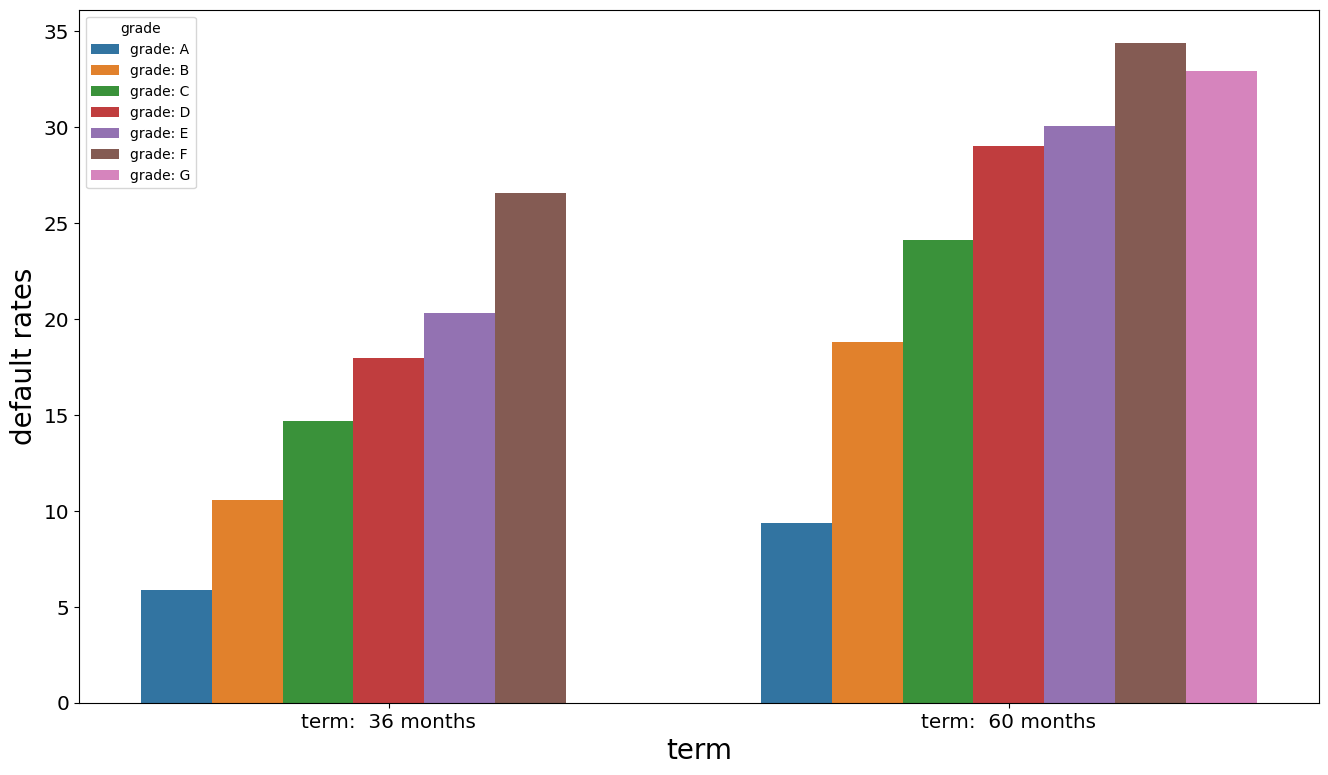

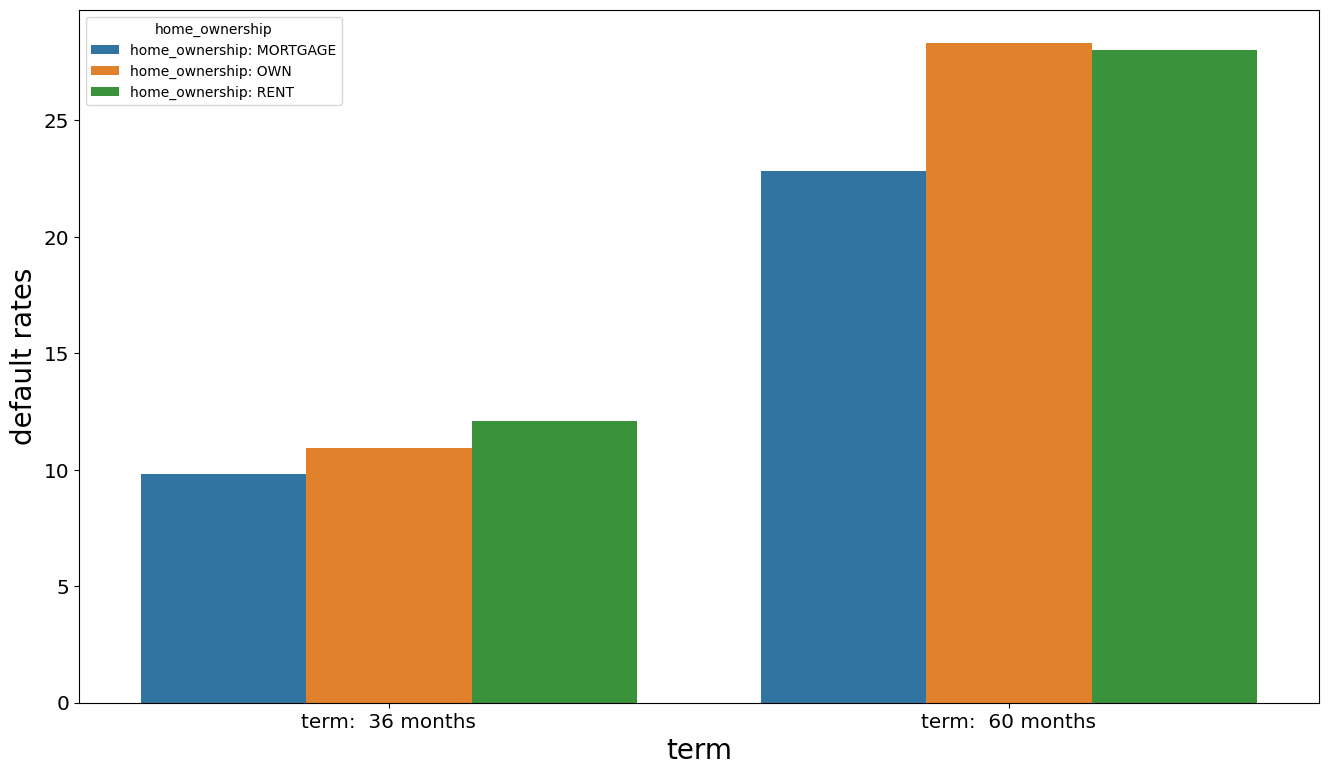

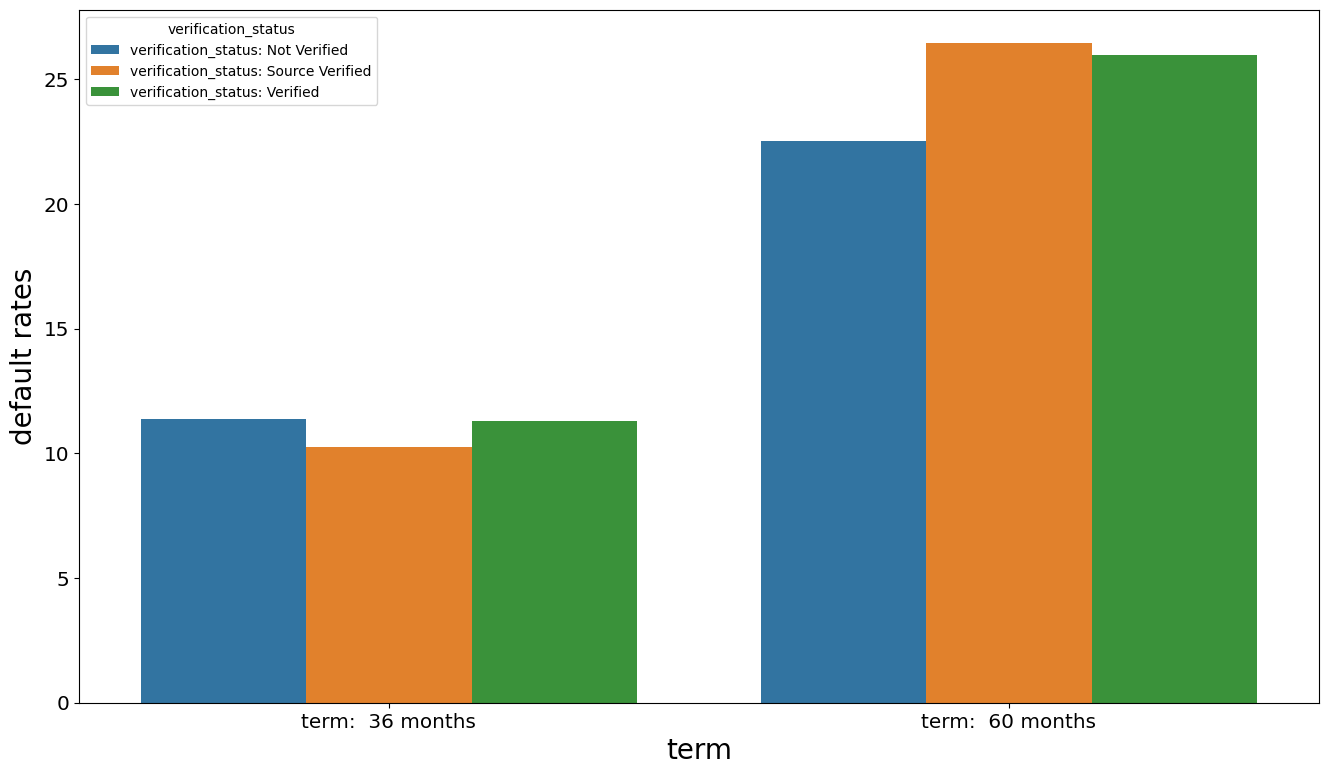

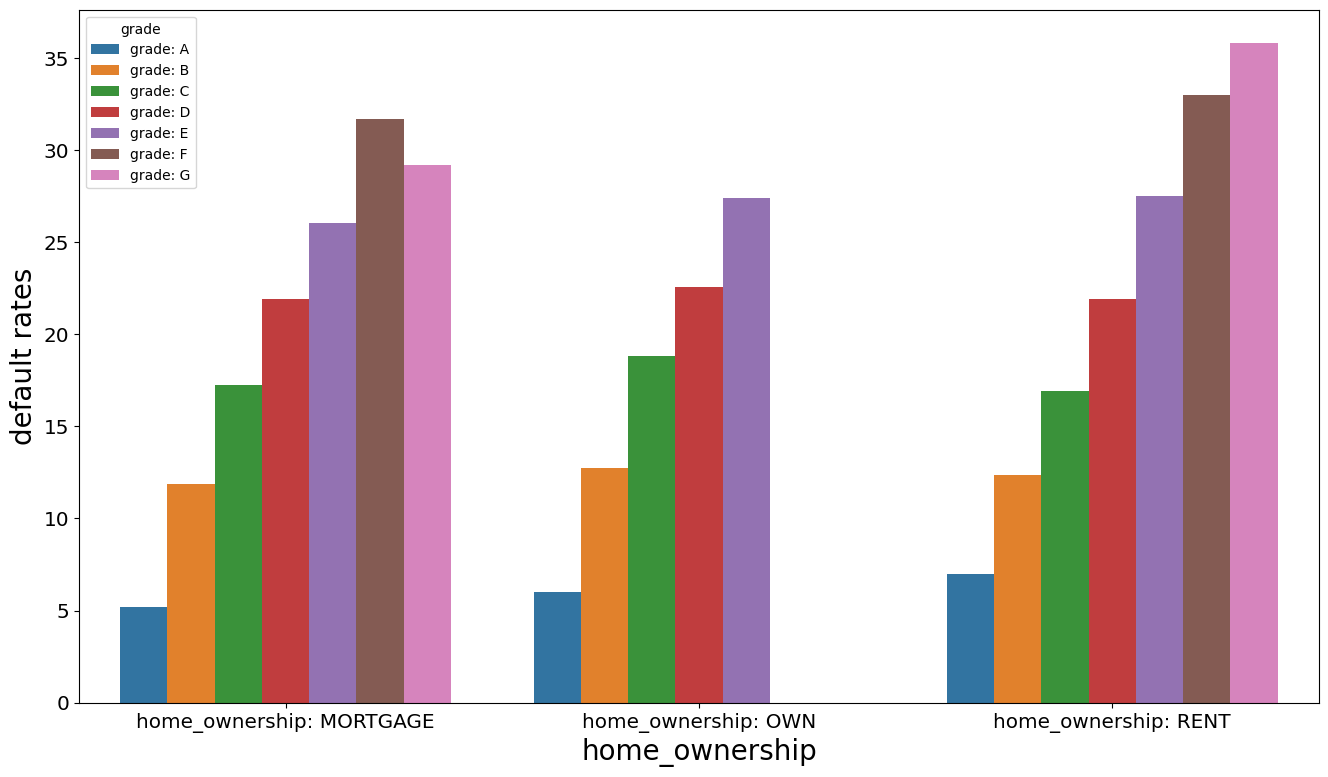

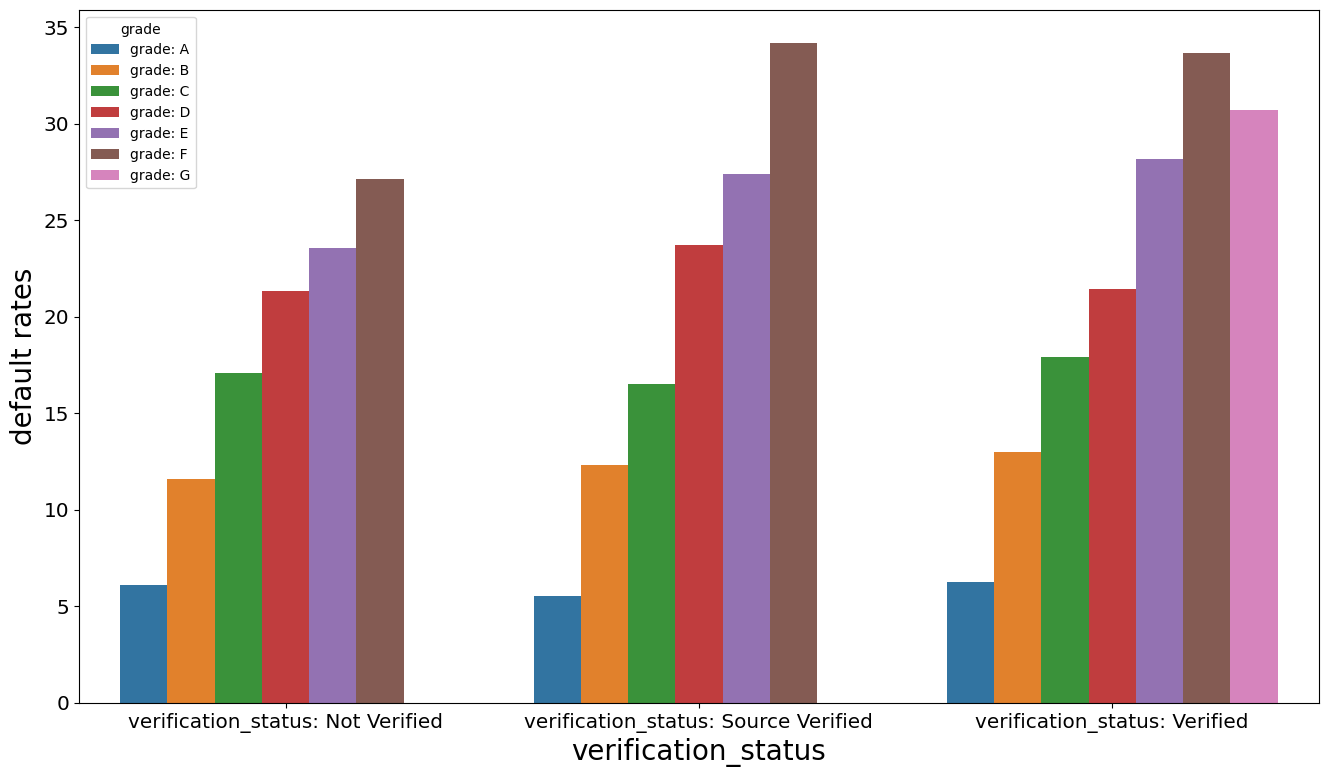

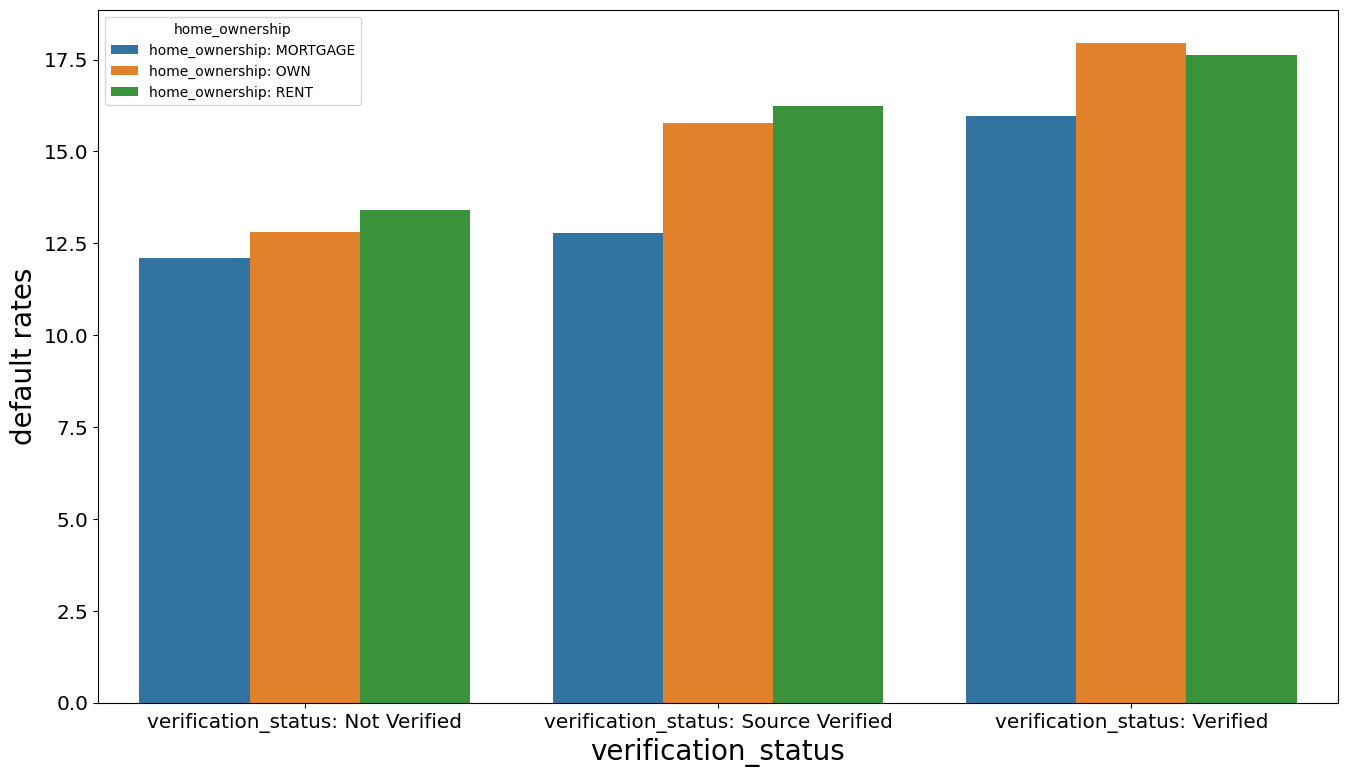

In [580]:
# display the grouped bar plot for further visualizing bivarate analysis data 
# only show data with less then 10 unique values
for index, row in cat_comb.iterrows():
    pivottable_ = create_pivot_bivar(row[0], row[1], 100)
    if (df[row[0]].nunique()<=10) & (df[row[1]].nunique()<=10):
        if df[row[0]].nunique()<df[row[1]].nunique():
            sns.barplot(x=row[0], y='default rates', hue=row[1], data=pivottable_)
            plt.xlabel(row[0], fontsize=20)
        else:
            sns.barplot(x=row[1], y='default rates', hue=row[0], data=pivottable_)
            plt.xlabel(row[1], fontsize=20)
        plt.ylabel('default rates',fontsize=20)
        plt.yticks(fontsize='x-large')
        plt.xticks(fontsize='x-large') 
        plt.show()
    continue